In [56]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

from inspect import trace
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm.auto import tqdm
import datetime
import stats
import scipy

import warnings
warnings.filterwarnings('ignore')

In [57]:
# to remain same mean and variance, we can do significant test for rejection area, that's the reveerting point

In [58]:
data = pdr.get_data_yahoo('QQQ')[['Adj Close']]
data['log_ret'] = np.log(data['Adj Close']).diff()
data

[*********************100%***********************]  1 of 1 completed


,Adj Close,log_ret
Date,,
1999-03-10,43.838387,NaN
1999-03-11,44.053017,0.004884
1999-03-12,42.979874,-0.024662
1999-03-15,44.213993,0.028309
1999-03-16,44.589619,0.008460
...,...,...
2023-04-03,320.149994,-0.002433
2023-04-04,319.070007,-0.003379
2023-04-05,315.920013,-0.009921


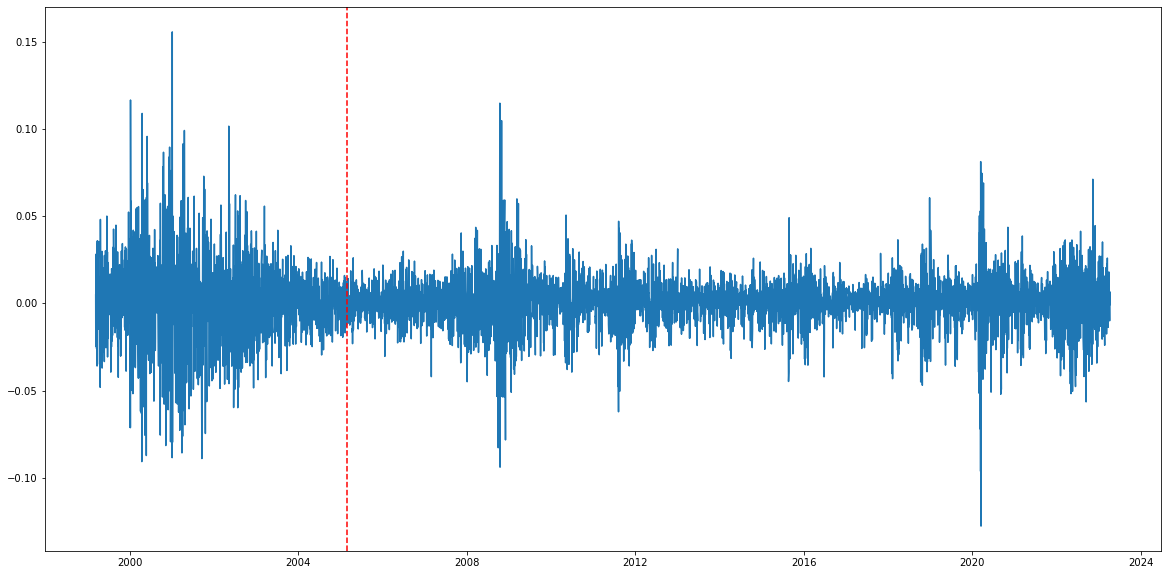

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(data['log_ret'])
# mark the 1500 days mark with vertical line
plt.axvline(x=data.index[1500], color='r', linestyle='--')
plt.show()

In [63]:
# historical 1500 days 2std line
stationary_mean = data[:1500]['log_ret'].mean()
stationary_std = data[:1500]['log_ret'].std()


data['p_value'] = None




for i in range(1500, len(data)):
    # get the 1500 days data
    historical = data.iloc[:i, :]
    # get the 1500 days mean and std
    historical_mean = historical['log_ret'].mean()
    historical_std = historical['log_ret'].std()
    
    equal_var = False
    # ifvar ratio less than 4:1 for larger:smaller, then we can use equal variance
    if historical_std ** 2 < 4 * stationary_std ** 2:
        equal_var = True
        
    # find the p value, statistic is x-u/ std/sqrt(n), use z table to find the p value
    p_value = scipy.stats.ttest_ind(historical['log_ret'][1:], data['log_ret'][1:1500], equal_var=equal_var)[1]
    data.iloc[i, -1] = p_value
    
    
    



In [64]:
data

,Adj Close,log_ret,p_value
Date,,,
1999-03-10,43.838387,NaN,None
1999-03-11,44.053017,0.004884,None
1999-03-12,42.979874,-0.024662,None
1999-03-15,44.213993,0.028309,None
1999-03-16,44.589619,0.008460,None
...,...,...,...
2023-04-03,320.149994,-0.002433,0.342009
2023-04-04,319.070007,-0.003379,0.342386
2023-04-05,315.920013,-0.009921,0.342906


In [67]:
threshold = 0.2

for i in range(1500, len(data)-1):
    if data.iloc[i, -1] < threshold:
        print(data.index[i])
            

    

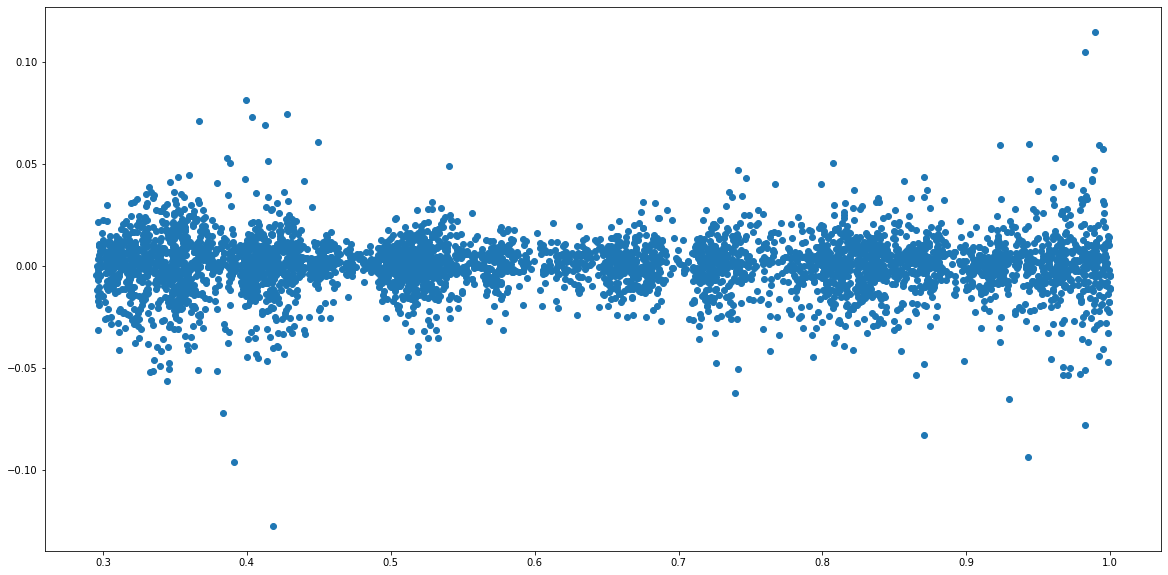

In [65]:
# plot aginast p_value and next day log return
plt.figure(figsize=(20, 10))
x = data[1500:-1]['p_value']
y = data[1501:]['log_ret']

# plt.scatter(x, y)
plt.scatter(x, y)


In [69]:
highest_p = 0

In [70]:
# backtest
temp = data.copy()
temp['stationary'] = None
import statsmodels.api as sm

for i in tqdm(range(1500, len(temp))):
    # check stationary
    stationary = sm.tsa.stattools.adfuller(temp.iloc[1:i, 1])
    if stationary[1] < 0.05:
        temp.iloc[i, -1] = 1
        
    if stationary[1] > highest_p:
        highest_p = stationary[1]
        
        
    

100%|██████████| 4561/4561 [06:44<00:00, 11.29it/s]


In [71]:
highest_p

8.146737977285699e-14